In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import pymc3 as pm

%matplotlib inline

In [64]:
senate = pd.read_csv('./data/senate.csv')

In [65]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612


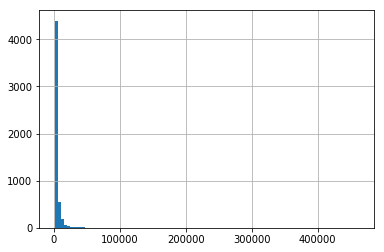

In [29]:
senate[senate['retweet_count'] > 1000].retweet_count.hist(bins=100)

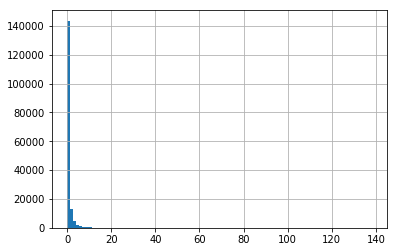

In [30]:
senate[senate['the_ratio'] > 0 ].the_ratio.hist(bins=100)

In [67]:
senate['z'] = np.log1p(senate.the_ratio)

In [68]:
senate.head()

,created_at,id_str,reply_count,retweet_count,text,user,name,state,party,the_ratio,z
0,Sun May 21 19:26:26 +0000 2017,8.660000e+17,116.0,174.0,"Franni here. Since it's Al's birthday, and sin...",alfranken,Al Franken,New York,Democratic,0.666667,0.510826
1,Tue May 16 01:44:44 +0000 2017,8.640000e+17,718.0,1248.0,This is profoundly troubling. Why would Presid...,alfranken,Al Franken,New York,Democratic,0.575321,0.454459
2,Wed May 10 19:55:37 +0000 2017,8.620000e+17,218.0,1334.0,It couldn't be clearer: we need an independent...,alfranken,Al Franken,New York,Democratic,0.163418,0.151362
3,Wed May 10 19:54:55 +0000 2017,8.620000e+17,134.0,794.0,More troubling news: AG Sessions was involved ...,alfranken,Al Franken,New York,Democratic,0.168766,0.155948
4,Wed May 10 19:54:20 +0000 2017,8.620000e+17,131.0,556.0,Troubling news that you probably know by now: ...,alfranken,Al Franken,New York,Democratic,0.235612,0.211566


In [69]:
np.var(senate['the_ratio'])

3.4122469061637255

In [70]:
senate.the_ratio.mean()

0.6773362343539384

Gamma dist:

mean = alpha*Beta

Variance = alpha*(Beta**2)

### Getting the ratio for Democrats and Republicans

In [71]:
the_ratio_dem = senate[senate['party'] =='Democratic'].the_ratio.values
the_ratio_rep = senate[senate['party'] =='Republican'].the_ratio.values

In [72]:
print(the_ratio_dem.mean(), the_ratio_dem.var())
print(the_ratio_rep.mean(), the_ratio_rep.var())

0.37668160435989506 0.7342832379182765
0.9539370092177968 5.682548775324917


<a id='freq-ttest'></a>
### Perform a Frequentist t-test of the mean the_ratio difference between groups.

In [73]:
tt = stats.ttest_ind(the_ratio_rep, the_ratio_dem)
print(tt.statistic)
print(tt.pvalue)

72.1505574553688
0.0


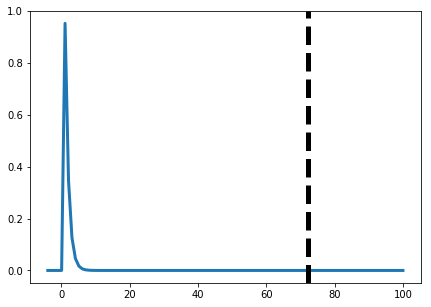

In [74]:
# THIS MAY OR MAYNOT BE USEFUL
zdist = stats.gamma(1,1)
xvals = np.linspace(-4, 100, 104)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xvals, zdist.pdf(xvals), lw=3)
ax.axvline(tt.statistic, color='black', ls='dashed', lw=5)
plt.show()

<a id='priors'></a>
### Set up the bayesian model with priors on mean APMs

Next we'll go through the steps of the Bayesian estimation of the difference between means using `pymc3`.

First we find the mean and standard deviation of the_ratio regardless of partisanship. We can going to use these values to inform our prior belief about the_ratio.

In [75]:
prior_mean = senate.the_ratio.mean()
prior_std = senate.the_ratio.std()

print(prior_mean, prior_std)

0.6773362343539384 1.847231022102251


In [76]:
with pm.Model() as model:
    dem_mean = pm.Gamma('ratio_dem_mean', 
                         alpha = 0.134, 
                         beta = 5.039)
    rep_mean = pm.Gamma('ratio_rep_mean', 
                         alpha = 0.134, 
                         beta = 5.039)

In [77]:
# A: P(mu_apm, std_apm)
prior_std_lower = 0.000001
prior_std_upper = 100.0

with model:
    dem_std = pm.Uniform('ratio_dem_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)
    rep_std = pm.Uniform('ratio_rep_std',
                          lower=prior_std_lower,
                          upper=prior_std_upper)

In [78]:
# A: P(data | mu, std)
with model:
    dem = pm.Gamma('ratio_dem_like',
                    observed = the_ratio_dem,
                    alpha = 0.514,
                    beta = 1.940)
    rep = pm.Gamma('ratio_rep_like',
                    observed = the_ratio_rep,
                    alpha = 0.168,
                    beta = 5.957)

In [79]:
with model:
    diff_of_means = pm.Deterministic('mean_diff',
                                      rep_mean - dem_mean)
    diff_of_std = pm.Deterministic('std_diff',
                                    rep_std - dem_std)

In [81]:
# A:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ratio_rep_std_interval__, ratio_dem_std_interval__, ratio_rep_mean_log__, ratio_dem_mean_log__]
  0%|          | 0/10500 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/reef/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/reef/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x103cbc660, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/reef/.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x103cbc660, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/reef/.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method PollIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# A:\nwith model:\n    trace = pm.sample(10000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 18, 4, 54, 462624, tzinfo=tzutc()), 'msg_id': '7ca9d1015b3440aa93bf0c5e080f762d', 'msg_type': 'execute_request', 'session': 'f622455d736648a190622fa76f732796', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7ca9d1015b3440aa93bf0c5e080f762d', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'f622455d736648a190622fa76f732796']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# A:\nwith model:\n    trace = pm.sample(10000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 18, 4, 54, 462624, tzinfo=tzutc()), 'msg_id': '7ca9d1015b3440aa93bf0c5e080f762d', 'msg_type': 'execute_request', 'session': 'f622455d736648a190622fa76f732796', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7ca9d1015b3440aa93bf0c5e080f762d', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'f622455d736648a190622fa76f732796'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# A:\nwith model:\n    trace = pm.sample(10000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 18, 4, 54, 462624, tzinfo=tzutc()), 'msg_id': '7ca9d1015b3440aa93bf0c5e080f762d', 'msg_type': 'execute_request', 'session': 'f622455d736648a190622fa76f732796', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7ca9d1015b3440aa93bf0c5e080f762d', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# A:\nwith model:\n    trace = pm.sample(10000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# A:\nwith model:\n    trace = pm.sample(10000)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# A:\nwith model:\n    trace = pm.sample(10000)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# A:\nwith model:\n    trace = pm.sample(10000)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# A:\nwith model:\n    trace = pm.sample(10000)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-81-01a9e3a75e03>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1c25122e48, execution..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1c20dfb930, file "<ipython-input-81-01a9e3a75e03>", line 2>
        result = <ExecutionResult object at 1c25122e48, execution..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1c20dfb930, file "<ipython-input-81-01a9e3a75e03>", line 2>, result=<ExecutionResult object at 1c25122e48, execution..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1c20dfb930, file "<ipython-input-81-01a9e3a75e03>", line 2>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport se..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport se..._ipython().run_line_magic('matplotlib', 'inline')", "senate = pd.read_csv('./data/senate.csv')", 'senate.head()', 'senate.info()', "senate.sort_values('the_ratio', ascending=False).head()", 'senate.dropna(inplace=True)', "senate.sort_values('the_ratio', ascending=False).head()", "senate['z'] = np.log1p(senate.the_ratio)", 'senate.head()', "senate.sort_values('the_ratio', ascending=False).head()", "senate[senate['z'] > 0 ].the_ratio.hist(bins=100)", "senate[senate['z'] > 0 ].the_ratio.hist(bins=50)", "senate[senate['z'] > 0 ].the_ratio.hist(bins=100)", 'senate.z.mean()', 'senate.z.var()', "z_dem = senate[senate['party'] =='Democratic'].z...))\nprint('Republican:' z_rep.mean(), z_rep.var())", "z_dem = senate[senate['party'] =='Democratic'].z...))\nprint('Republican': z_rep.mean(), z_rep.var())", "z_dem = senate[senate['party'] =='Democratic'].z...))\nprint('Republican', z_rep.mean(), z_rep.var())", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {4:                        created_at        id_str ...  0.168766  
4  New York  Democratic   0.235612  , 6:                             created_at        id...l cassidy     Louisiana  Republican   96.000000  , 8:                             created_at        id...l cassidy     Louisiana  Republican   96.000000  , 10:                        created_at        id_str ...  
4  New York  Democratic   0.235612  0.211566  , 11:                             created_at        id... 4.691348  
36978   4.579852  
15547   4.574711  , 12: <matplotlib.axes._subplots.AxesSubplot object>, 13: <matplotlib.axes._subplots.AxesSubplot object>, 14: <matplotlib.axes._subplots.AxesSubplot object>, 15: 0.36119891517670105, 16: 0.20235818469400238, ...}, 'PorterStemmer': <class 'nltk.stem.porter.PorterStemmer'>, 'RegexpTokenizer': <class 'nltk.tokenize.regexp.RegexpTokenizer'>, '_': 0.6773362343539384, '_10':                        created_at        id_str ...  
4  New York  Democratic   0.235612  0.211566  , '_11':                             created_at        id... 4.691348  
36978   4.579852  
15547   4.574711  , '_12': <matplotlib.axes._subplots.AxesSubplot object>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport se..._ipython().run_line_magic('matplotlib', 'inline')", "import pandas as pd\nimport numpy as np\nimport se..._ipython().run_line_magic('matplotlib', 'inline')", "senate = pd.read_csv('./data/senate.csv')", 'senate.head()', 'senate.info()', "senate.sort_values('the_ratio', ascending=False).head()", 'senate.dropna(inplace=True)', "senate.sort_values('the_ratio', ascending=False).head()", "senate['z'] = np.log1p(senate.the_ratio)", 'senate.head()', "senate.sort_values('the_ratio', ascending=False).head()", "senate[senate['z'] > 0 ].the_ratio.hist(bins=100)", "senate[senate['z'] > 0 ].the_ratio.hist(bins=50)", "senate[senate['z'] > 0 ].the_ratio.hist(bins=100)", 'senate.z.mean()', 'senate.z.var()', "z_dem = senate[senate['party'] =='Democratic'].z...))\nprint('Republican:' z_rep.mean(), z_rep.var())", "z_dem = senate[senate['party'] =='Democratic'].z...))\nprint('Republican': z_rep.mean(), z_rep.var())", "z_dem = senate[senate['party'] =='Democratic'].z...))\nprint('Republican', z_rep.mean(), z_rep.var())", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {4:                        created_at        id_str ...  0.168766  
4  New York  Democratic   0.235612  , 6:                             created_at        id...l cassidy     Louisiana  Republican   96.000000  , 8:                             created_at        id...l cassidy     Louisiana  Republican   96.000000  , 10:                        created_at        id_str ...  
4  New York  Democratic   0.235612  0.211566  , 11:                             created_at        id... 4.691348  
36978   4.579852  
15547   4.574711  , 12: <matplotlib.axes._subplots.AxesSubplot object>, 13: <matplotlib.axes._subplots.AxesSubplot object>, 14: <matplotlib.axes._subplots.AxesSubplot object>, 15: 0.36119891517670105, 16: 0.20235818469400238, ...}, 'PorterStemmer': <class 'nltk.stem.porter.PorterStemmer'>, 'RegexpTokenizer': <class 'nltk.tokenize.regexp.RegexpTokenizer'>, '_': 0.6773362343539384, '_10':                        created_at        id_str ...  
4  New York  Democratic   0.235612  0.211566  , '_11':                             created_at        id... 4.691348  
36978   4.579852  
15547   4.574711  , '_12': <matplotlib.axes._subplots.AxesSubplot object>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/reef/dsi/Projects/Capstone/<ipython-input-81-01a9e3a75e03> in <module>()
      1 # A:
      2 with model:
----> 3     trace = pm.sample(10000)

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=10500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)}, {'ratio_dem_mean_log__': array(-3.51510421), 'ratio_dem_std_interval__': array(0.04972884), 'ratio_rep_mean_log__': array(-3.17318038), 'ratio_rep_std_interval__': array(0.32805788)}, {'ratio_dem_mean_log__': array(-2.71013003), 'ratio_dem_std_interval__': array(0.15764348), 'ratio_rep_mean_log__': array(-3.97791512), 'ratio_rep_std_interval__': array(-0.00471864)}, {'ratio_dem_mean_log__': array(-4.44220304), 'ratio_dem_std_interval__': array(-0.44182391), 'ratio_rep_mean_log__': array(-4.54057767), 'ratio_rep_std_interval__': array(-0.35444256)}], trace=None, chain_idx=0, chains=4, njobs=4, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[606274741, 455790063, 425410589, 136584993], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 4, 'draws': 10500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 4, 'progressbar': True, 'random_seed': [606274741, 455790063, 425410589, 136584993], 'start': [{'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)}, {'ratio_dem_mean_log__': array(-3.51510421), 'ratio_dem_std_interval__': array(0.04972884), 'ratio_rep_mean_log__': array(-3.17318038), 'ratio_rep_std_interval__': array(0.32805788)}, {'ratio_dem_mean_log__': array(-2.71013003), 'ratio_dem_std_interval__': array(0.15764348), 'ratio_rep_mean_log__': array(-3.97791512), 'ratio_rep_std_interval__': array(-0.00471864)}, {'ratio_dem_mean_log__': array(-4.44220304), 'ratio_dem_std_interval__': array(-0.44182391), 'ratio_rep_mean_log__': array(-4.54057767), 'ratio_rep_std_interval__': array(-0.35444256)}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 10500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 4
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Mar 28 14:05:01 2018
PID: 12207                   Python 3.6.3: /Users/reef/anaconda3/bin/python
...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 606274741, {'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)}), {'draws': 10500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 606274741, {'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)})
        kwargs = {'draws': 10500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=606274741, start={'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)}, draws=10500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/10500 [00:01<?, ?it/s]
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/10500 [00:01<?, ?it/s])
    948             except AttributeError:
    949                 raise TqdmDeprecationWarning("""\
    950 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    951 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    952 
--> 953             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    954                 yield obj
    955                 # Update and possibly print the progressbar.
    956                 # Note: does not call self.update(1) for speed optimisation.
    957                 n += 1

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=10500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=606274741)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)}
        states = undefined
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'ratio_dem_mean_log__': array(-3.85365685), 'ratio_dem_std_interval__': array(0.33251673), 'ratio_rep_mean_log__': array(-3.71459111), 'ratio_rep_std_interval__': array(0.53691369)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([ 0.53691369,  0.33251673, -3.71459111, -3.85365685])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/Users/reef/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([ 0.53691369,  0.33251673, -3.71459111, -3.85365685]))
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
    115             self.potential.raise_ok()
    116             raise ValueError('Bad initial energy: %s. The model '
--> 117                              'might be misspecified.' % start.energy)
        start.energy = inf
    118 
    119         adapt_step = self.tune and self.adapt_step_size
    120         step_size = self.step_adapt.current(adapt_step)
    121         self.step_size = step_size

ValueError: Bad initial energy: inf. The model might be misspecified.
___________________________________________________________________________

In [60]:
### nump.log1p - transform the ratio into 

## mean and variance of Z (new target variabe)

In [83]:
senate.z.mean(), senate.z.var()

(0.36119891517670105, 0.20235818469400238)

In [22]:
z_dem = senate[senate['party'] =='Democratic'].z.values
z_rep = senate[senate['party'] =='Republican'].z.values

print('Democrat', z_dem.mean(), z_dem.var())
print('Republican', z_rep.mean(), z_rep.var())

Democrat 0.25661434708288705 0.09123438607177879
Republican 0.4588512619374477 0.28339384664220113


In [55]:
tt = stats.ttest_ind(z_rep, z_dem)
print(tt.statistic)
print(tt.pvalue)

105.64033822739268
0.0


In [ ]:
with pm.Model() as model:
    dem_mean = pm.Gamma('ratio_dem_mean', 
                         alpha = 0.134, 
                         beta = 5.039)
    rep_mean = pm.Gamma('ratio_rep_mean', 
                         alpha = 0.134, 
                         beta = 5.039)